In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt

from cppn import CPPN, Sampler

from PIL import Image
import pygame
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm

C:\Users\Heysoos\anaconda3\envs\torchstuff\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


pygame 2.1.2 (SDL 2.0.18, Python 3.9.15)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
class Rule(nn.Module):
    def __init__(self, RES, RADIUS=2):
        super().__init__()
        self.radius = RADIUS

        self.eta = 0.05
        self.target_rate = 1.
        self.excite_prob = .8
        self.constant_current = 0.01

        self.plasticity = True
        self.plastic_lr = 1e-1

        self.afunc = torch.sigmoid


        self.RES = RES
        RESX, RESY = RES[0], RES[1]
        self.NUMEL = RESX * RESY

        ########## CPPN KERNEL ################
        cppn_net_size = [32, 32, 32]
        # cppn_net_size = [1]
        dim_z = 16
        dim_c = self.NUMEL  # CHANNELS
        self.cppn = CPPN(cppn_net_size, dim_z, dim_c).cuda().eval()
        self.sampler = Sampler()
        self.nearest_neighbours = self.generate_cppn_kernel()


    def generate_cppn_kernel(self):
        scale = 5
        zscale = 2
        z = zscale * torch.randn(1, self.cppn.dim_z).cuda()
        Rk = self.radius * 2 + 1
        coords = self.cppn._coordinates(scale, Rk, Rk, z)
        coords[0] = torch.rand_like(coords[0])
        coords[1] = torch.rand_like(coords[0])
        coords[2] = torch.rand_like(coords[0])


        k = self.cppn.forward(coords, Rk, Rk).reshape(1, Rk, Rk, self.cppn.dim_c).permute(0, 3, 1, 2)


        # local kernels
        k = k.permute(0, 2, 3, 1)
        k[:, self.radius, self.radius, :] = 0
        k = k.view(1, -1, self.NUMEL)

        return k

    def forward(self, x, noise_input):

        Rk = self.radius

        V = x[:, [0], ...] + noise_input
        V_EI = F.pad(V * self.EI, (Rk, Rk, Rk, Rk), 'constant', 0.) #spikes

        I = F.unfold(V_EI, 2 * Rk + 1) * self.nearest_neighbours # * self.rm
        I = I.sum(dim=1).view(1, 1, self.RES[0], self.RES[1])

        V = (1 - self.eta) * V + self.eta * (1 - V) * self.afunc(I)

        if self.plasticity:
            pre = F.unfold(F.pad(V, (Rk, Rk, Rk, Rk), 'constant', 0.), 2 * Rk + 1)
            post = F.unfold(V, 1)  # pre-trace

            delta_E = (pre * post) * (~self.if_inhib)
            delta_I = pre * (post - self.target_rate * self.ym) * self.if_inhib
            delta = delta_E + delta_I
            delta[:, Rk * (2 * Rk + 1) + Rk, :] = 0  # set center pixel to 0
            # delta = delta * (self.nearest_neighbours > 1e-6)

            new_k = torch.clip(self.nearest_neighbours + self.plastic_lr * delta, min=0)
            new_k[:, Rk * (2 * Rk + 1) + Rk, :] = 0  # set center pixel to 0
            new_k_I = new_k * self.if_inhib
            new_k_I = new_k_I / (new_k_I.sum(dim=1) + 1e-6) * self.k_sums_I
            new_k_E = new_k * (~self.if_inhib)
            new_k_E = new_k_E / (new_k_E.sum(dim=1) + 1e-6) * self.k_sums_E
            new_k = new_k_I + new_k_E
            self.nearest_neighbours = 0.5 * self.nearest_neighbours + 0.5 * new_k

        z = torch.cat([V, self.EI], axis=1)
        return z

class rateCA_local(nn.Module):
    def __init__(self, RES=(640,640), RADIUS=2):
        super().__init__()
        self.radius = RADIUS
        self.RES = RES
        RESX, RESY = RES[0], RES[1]
        self.rule = Rule((RESX, RESY), RADIUS)

        self.noise = True
        self.first_run = True


    def initGrid(self, reinit=False):
        shape = self.RES
        rand = torch.rand(1, 1, shape[0], shape[1]) * 2.
        rand[0, 0] = (rand[0, 0] > 0.8) * 1.

        xm, ym = torch.meshgrid(torch.linspace(-1, 1, shape[0]), shape[1] / shape[0] * torch.linspace(-1, 1, shape[1]))
        
        xm = (xm + 1.) / 2.
        ym = (ym + 1.) / 2.
        
        # self.rule.xm = F.unfold(xm.unsqueeze(0).unsqueeze(0), 1).cuda()
        self.rule.ym = F.unfold(ym.unsqueeze(0).unsqueeze(0), 1).cuda()
        # self.rm = torch.sqrt(xm ** 2 + ym ** 2).cuda()

        if reinit:
            self.rule = Rule((self.RES[0], self.RES[1]), self.radius)

        if self.first_run or reinit:

            self.rule.EI = ((torch.rand(1, 1, shape[0], shape[1]) < xm) * 2. - 1).cuda()
            self.rule.EI = torch.where(self.rule.EI < 0., self.rule.EI * (1 / (1 - self.rule.excite_prob + 1e-6)),
                                       self.rule.EI)

            Rk = self.rule.radius
            self.rule.if_inhib = (F.unfold(F.pad(self.rule.EI, (Rk, Rk, Rk, Rk), 'circular'), 2 * Rk + 1) < 0.)
            self.rule.k_sums_E = (self.rule.nearest_neighbours * (~self.rule.if_inhib)).sum(dim=1)
            self.rule.k_sums_I = (self.rule.nearest_neighbours * self.rule.if_inhib).sum(dim=1)

            self.first_run = False
        return torch.cat([rand.cuda(), self.rule.EI], axis=1)

    def forward(self, x):
        if self.noise:
            # noise_input = (torch.rand_like(x[:, [1], ...]) < 0.0002) * 1.
            noise_input = torch.rand_like(x[:, [1], ...]) * self.rule.constant_current * (torch.rand_like(x[:, [1], ...]) > 0.9)
        else:
            noise_input = 0.
        return self.rule(x, noise_input)


### Make inhibitory/excitatory balance go from [0, 1] on the x axis

In [3]:
RADIUS=10

RESX=480
RESY=480

with torch.no_grad():
    ca = rateCA_local((RESX, RESY), RADIUS=RADIUS).cuda().eval()    
    state = ca.initGrid()    
    ca.rule.plasticity = True

C:\Users\Heysoos\anaconda3\envs\torchstuff\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [72]:
timesteps = 1500
capture_frames = [1, 50, 100, timesteps]

imgs_all = []
for i in tqdm(range(timesteps)):
    state = ca.forward(state)
    
    imgs_all.append(state[0, 0].cpu().numpy())

100%|██████████| 1500/1500 [00:38<00:00, 38.97it/s]


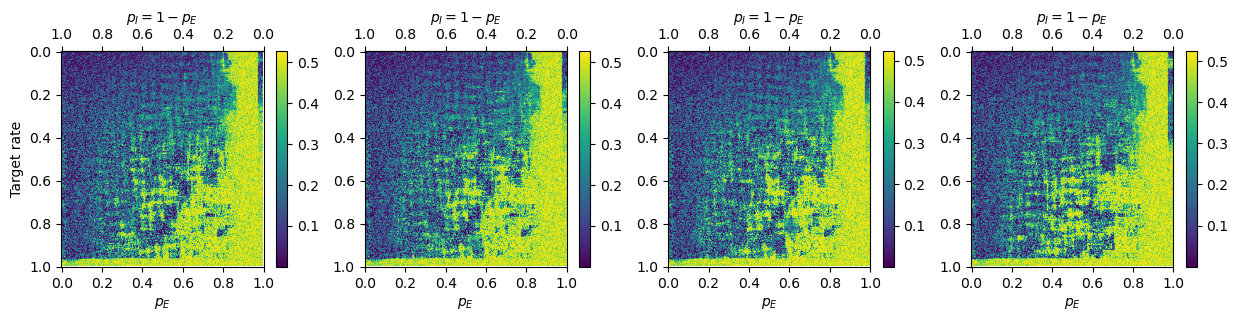

In [73]:
imgs = [imgs_all[idx - 1] for idx in capture_frames]

fig, axes = plt.subplots(1, len(capture_frames), figsize=(15, 2.8))

for i, ax in enumerate(axes):
    im = ax.imshow(imgs[i].T)
    ax.set_xticks(np.linspace(0, RESX, 6), labels=[f'{i:.1f}' for i in np.linspace(0, 1, 6)]);
    ax.set_xlabel(r'$p_E$')
    
    ax2 = ax.secondary_xaxis('top')
    ax2.set_xticks(np.linspace(0, RESX, 6), labels=[f'{i:.1f}' for i in np.linspace(1, 0, 6)]);
    ax2.set_xlabel(r'$p_I = 1 - p_E$')
    ax2.tick_params(axis='x', direction='out')
    
    plt.colorbar(im, ax=ax, shrink=1.)
    
    ax.set_yticks(np.linspace(0, RESY, 6), labels=[f'{i:.1f}' for i in np.linspace(0, 1, 6)]);
    if i == 0:
        ax.set_ylabel('Target rate')
    ax.set_aspect('auto')
    # ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False)

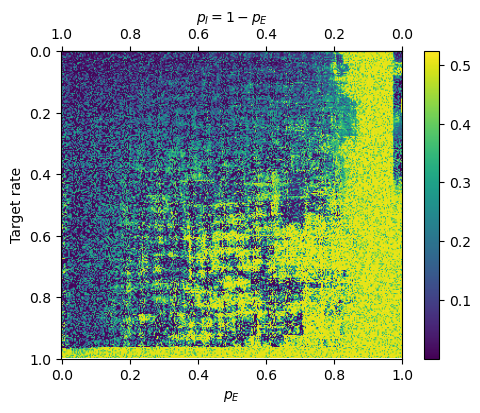

In [74]:
fig, ax = plt.subplots(1, figsize=(5.5 ,4))

im = ax.imshow(imgs[-1].T)
ax.set_xticks(np.linspace(0, RESX, 6), labels=[f'{i:.1f}' for i in np.linspace(0, 1, 6)]);
ax.set_xlabel(r'$p_E$')

ax2 = ax.secondary_xaxis('top')
ax2.set_xticks(np.linspace(0, RESX, 6), labels=[f'{i:.1f}' for i in np.linspace(1, 0, 6)]);
ax2.set_xlabel(r'$p_I = 1 - p_E$')
ax2.tick_params(axis='x', direction='out')

plt.colorbar(im, ax=ax, shrink=1.)

ax.set_yticks(np.linspace(0, RESY, 6), labels=[f'{i:.1f}' for i in np.linspace(0, 1, 6)]);
ax.set_ylabel('Target rate')
ax.set_aspect('auto')


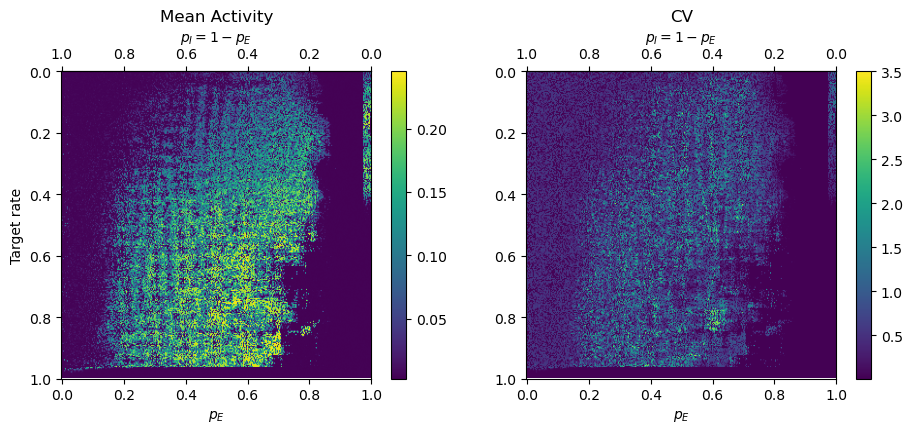

In [78]:
fig, axes = plt.subplots(1, 2, figsize=(2 * 5.5 ,4))

############## ax1 ##############
ax = axes[0]
img = np.std(np.array(imgs_all), axis=0)

im = ax.imshow(img.T)
ax.set_title('Mean Activity')
ax.set_xticks(np.linspace(0, RESX, 6), labels=[f'{i:.1f}' for i in np.linspace(0, 1, 6)]);
ax.set_xlabel(r'$p_E$')

ax2 = ax.secondary_xaxis('top')
ax2.set_xticks(np.linspace(0, RESX, 6), labels=[f'{i:.1f}' for i in np.linspace(1, 0, 6)]);
ax2.set_xlabel(r'$p_I = 1 - p_E$')
ax2.tick_params(axis='x', direction='out')

plt.colorbar(im, ax=ax, shrink=1.)

ax.set_yticks(np.linspace(0, RESY, 6), labels=[f'{i:.1f}' for i in np.linspace(0, 1, 6)]);
ax.set_ylabel('Target rate')
ax.set_aspect('auto')

############## ax2 ##############
ax = axes[1]
img = np.std(np.array(imgs_all), axis=0) / np.mean(np.array(imgs_all), axis=0)

im = ax.imshow(img.T)
ax.set_title('CV')
ax.set_xticks(np.linspace(0, RESX, 6), labels=[f'{i:.1f}' for i in np.linspace(0, 1, 6)]);
ax.set_xlabel(r'$p_E$')

ax2 = ax.secondary_xaxis('top')
ax2.set_xticks(np.linspace(0, RESX, 6), labels=[f'{i:.1f}' for i in np.linspace(1, 0, 6)]);
ax2.set_xlabel(r'$p_I = 1 - p_E$')
ax2.tick_params(axis='x', direction='out')

plt.colorbar(im, ax=ax, shrink=1.)

ax.set_yticks(np.linspace(0, RESY, 6), labels=[f'{i:.1f}' for i in np.linspace(0, 1, 6)]);
# ax.set_ylabel('Target rate')
ax.set_aspect('auto')

In [3]:
RADIUS=10
RESX=480
RESY=480

In [ ]:
timesteps = 500
buffer = 250
num_runs = 50

imgs_multirun = np.zeros((num_runs, timesteps - buffer, RESX, RESY))
with torch.no_grad():    
    for j in range(num_runs ):
        ca = rateCA_local((RESX, RESY), RADIUS=RADIUS).cuda().eval()    
        state = ca.initGrid()    
        ca.rule.plasticity = True

        imgs_all = []
        for i in tqdm(range(timesteps)):
            state = ca.forward(state)
            
            if i > buffer: # skip transient part
                imgs_multirun[j, i - buffer, :, :] = state[0, 0].cpu().numpy()

C:\Users\Heysoos\anaconda3\envs\torchstuff\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
 25%|██▌       | 126/500 [00:08<00:25, 14.94it/s]

In [9]:
imgs_multirun = np.array(imgs_multirun)

KeyboardInterrupt: 

In [8]:
# import pickle
# with open('phase_diagram_data.pickle', 'wb') as f:
#     pickle.dump(imgs_multirun, f)

MemoryError: 

MemoryError: Unable to allocate 27.9 GiB for an array with shape (50, 649, 480, 480) and data type float32

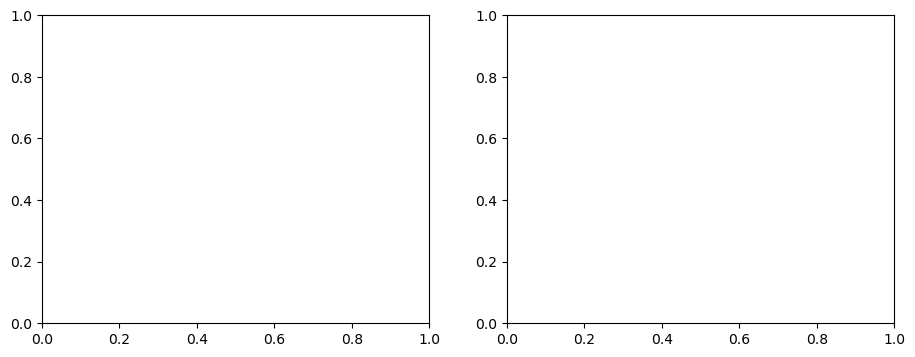

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(2 * 5.5 ,4))

############## ax1 ##############
ax = axes[0]
img = np.std(imgs_multirun, axis=(0, 1))

im = ax.imshow(img.T)
ax.set_title('Mean Activity')
ax.set_xticks(np.linspace(0, RESX, 6), labels=[f'{i:.1f}' for i in np.linspace(0, 1, 6)]);
ax.set_xlabel(r'$p_E$')

ax2 = ax.secondary_xaxis('top')
ax2.set_xticks(np.linspace(0, RESX, 6), labels=[f'{i:.1f}' for i in np.linspace(1, 0, 6)]);
ax2.set_xlabel(r'$p_I = 1 - p_E$')
ax2.tick_params(axis='x', direction='out')

plt.colorbar(im, ax=ax, shrink=1.)

ax.set_yticks(np.linspace(0, RESY, 6), labels=[f'{i:.1f}' for i in np.linspace(0, 1, 6)]);
ax.set_ylabel('Target rate')
ax.set_aspect('auto')

############## ax2 ##############
ax = axes[1]
img = np.std(imgs_multirun, axis=(0, 1)) / img

im = ax.imshow(img.T)
ax.set_title('CV')
ax.set_xticks(np.linspace(0, RESX, 6), labels=[f'{i:.1f}' for i in np.linspace(0, 1, 6)]);
ax.set_xlabel(r'$p_E$')

ax2 = ax.secondary_xaxis('top')
ax2.set_xticks(np.linspace(0, RESX, 6), labels=[f'{i:.1f}' for i in np.linspace(1, 0, 6)]);
ax2.set_xlabel(r'$p_I = 1 - p_E$')
ax2.tick_params(axis='x', direction='out')

plt.colorbar(im, ax=ax, shrink=1.)

ax.set_yticks(np.linspace(0, RESY, 6), labels=[f'{i:.1f}' for i in np.linspace(0, 1, 6)]);
# ax.set_ylabel('Target rate')
ax.set_aspect('auto')
plt.savefig('figs/rateCA_phase_diagram.pdf', bbox_inches='tight')

# Pygame

In [7]:
# brush properties
r = 20
s = 1

def LMB_make(state, r=5, s=1):
    '''
    left click to make
    r: radius of brush
    s: smoothing / sigma
    '''
    xcl, ycl = pygame.mouse.get_pos()
    xcl, ycl = int(xcl/UPSCALE), int(ycl/UPSCALE)
    
    # radial blur
    xm, ym = torch.meshgrid(torch.linspace(-1, 1, 2*r), torch.linspace(-1, 1, 2*r))
    rm = torch.sqrt(xm**2 + ym**2).type(torch.double)
    blur = torch.exp(-rm**2 / s**2)
    blur = torch.where(rm <= 1., blur, 0.) # circular mask
    
    xslice = range(xcl - r, xcl + r)
    yslice = range(ycl - r, ycl + r)
    for count_i, i in enumerate(xslice):
        for count_j, j in enumerate(yslice):
            i = i % RESX
            j = j % RESY
            # state[:, 0, i, j] = state[:, 1, i, j] + 5.
            state[:, 0, i, j] = 1.
    return state
    
    
def RMB_del(state, r=5, s=1):
    '''
    right click to erase
    r: radius of eraser
    s: smoothing / sigma
    '''
    xcl, ycl = pygame.mouse.get_pos()
    xcl, ycl = int(xcl/UPSCALE), int(ycl/UPSCALE)
    
    # radial blur
    xm, ym = torch.meshgrid(torch.linspace(-1, 1, 2*r), torch.linspace(-1, 1, 2*r))
    rm = torch.sqrt(xm**2 + ym**2).type(torch.double)
    blur = (1 - torch.exp(-rm**2 / s**2))
    blur = torch.where(rm <= 1., blur, 1.) # circular mask
    
    xslice = range(xcl - r, xcl + r)
    yslice = range(ycl - r, ycl + r)
    for count_i, i in enumerate(xslice):
        for count_j, j in enumerate(yslice):
            i = i % RESX
            j = j % RESY
            # state[:, 0, i, j] = state[:, 1, i, j] - 0.2
            state[:, 0, i, j] = 0.
    return state

def WHEEL_permute(cdim_order, direction):
    cdim_order = np.mod(np.add(cdim_order, direction), 2)
    
    return cdim_order

def min_max(mat):
    return (mat - mat.min()) / (mat.max() - mat.min())

In [8]:
RADIUS=10

RESX=320
RESY=280

kernel_increment = .2
with torch.no_grad():
    ca = rateCA_local((RESX, RESY), RADIUS=RADIUS).cuda()
    state = ca.initGrid()

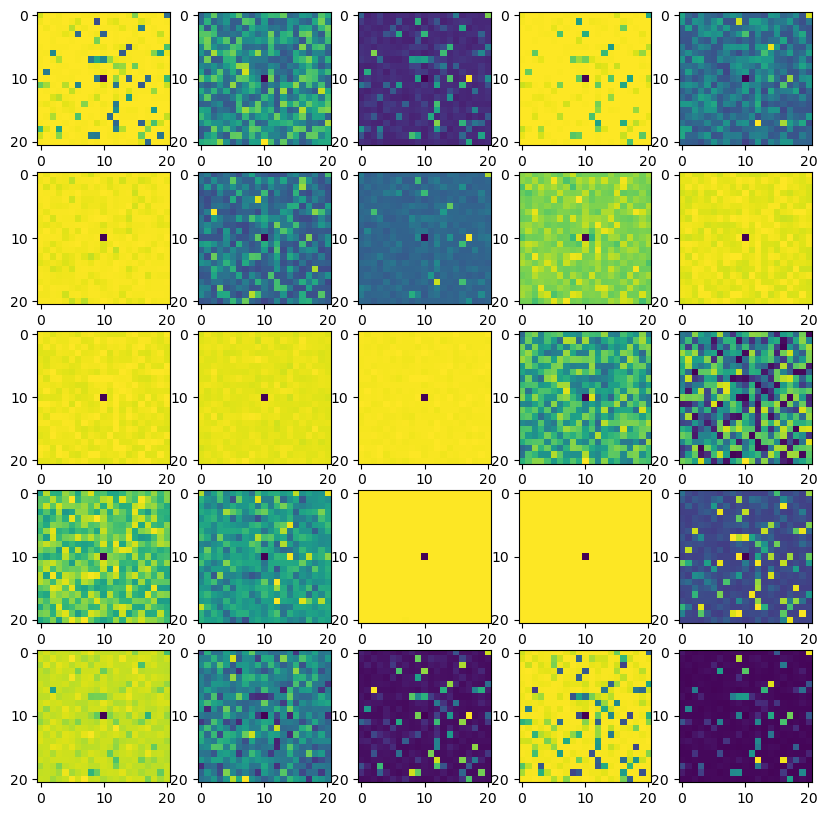

In [9]:
fig, axes = plt.subplots(5, 5, figsize=(10, 10))

for i, ax in enumerate(axes.flatten()):
    ax.imshow((ca.rule.nearest_neighbours).detach().cpu().numpy()[0, :, i*10].reshape(2*RADIUS + 1, 2*RADIUS + 1));

### Init Webcam

In [10]:
cap = cv2.VideoCapture(0)

# Check if the webcam is opened correctly
if not cap.isOpened():
    raise IOError("Cannot open webcam")


In [11]:
ret, web_frame = cap.read()
web_frame = cv2.resize(web_frame, None, fx=1, fy=1, interpolation=cv2.INTER_AREA)
web_frame = cv2.cvtColor(web_frame, cv2.COLOR_BGR2GRAY)

In [12]:
target_file = 'target/pug.png'
# target_file = 'target/stripes.jpg'
# target_file = 'target/diagonal-lines-1.jpg'
# target_file = 'target/checkerboard.jpg'
target_img = Image.open(target_file).convert('L')
target_img = target_img.resize((RESX,RESY), Image.ANTIALIAS)
target_img = np.array(target_img).transpose() / 255.0
# target_img = 1 - target_img
# target_img = (target_img - target_img.mean()) / target_img.std()
target_img = torch.cuda.FloatTensor(target_img)
inject_img = False

sign = 1.
t = 0
theta = 0.
X, Y = torch.meshgrid(torch.linspace(-1, 1, RESX), torch.linspace(-1, 1, RESY))

C:\Users\Heysoos\AppData\Local\Temp\ipykernel_21384\541605365.py:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  target_img = target_img.resize((RESX,RESY), Image.ANTIALIAS)


In [13]:
# pygame stuff
######################################
pygame.init()
size = RESX, RESY

win = pygame.display.set_mode((RESX, RESY))

screen = pygame.Surface(size)
UPSCALE = 2
RESXup, RESYup = int(RESX*UPSCALE), int(RESY*UPSCALE)
upscaled_screen = pygame.display.set_mode([RESXup, RESYup])

# webcam stuff
######################################
inject_webcam = False
wbcam_fx = RESX / web_frame.shape[1]
wbcam_fy = RESY / web_frame.shape[0] #RESY 
img_norm = 1/255. 

running = True
time_ticking = True
self_organize = False
LMB_trigger = False
RMB_trigger = False
WHEEL_trigger = False
cdim_order = np.arange(0, 6)

clock = pygame.time.Clock()
font = pygame.font.SysFont("Noto Sans", 12)
def update_fps(clock, font):
    fps = str(int(clock.get_fps()))
    fps_text = font.render(fps, 1, pygame.Color("white"))
    fps_bg = pygame.Surface((fps_text.get_height(),fps_text.get_width()))  # the size of your rect
    fps_bg.set_alpha(50)                # alpha level
    fps_bg.fill((255,255,255))           # this fills the entire surface

    fps_surf = pygame.Surface((fps_bg.get_height(), fps_bg.get_width()))
    fps_surf.blit(fps_bg, (0, 0))
    fps_surf.blit(fps_text, (0, 0))
    return fps_surf
######################################


state = ca.initGrid()
og_kernel = ca.rule.nearest_neighbours
kernel_scale = 1

# inject noise
signal_injection = torch.zeros(size=state.shape)
inject_increment = 1.
noise_amp = 1.
noise_idx = slice(4, 10)

update_rate = 1.
ticker = 0.
sink = False
export_imgs = False
imgs = []

with torch.no_grad():
    while running:              
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False
                
            if event.type == pygame.MOUSEBUTTONDOWN:
                if event.button == 1:
                    LMB_trigger = True
                if event.button == 3:
                    RMB_trigger = True
            if event.type == pygame.MOUSEBUTTONUP:
                if event.button == 1:
                    LMB_trigger = False
                if event.button == 3:
                    RMB_trigger = False
                    
            if event.type == pygame.MOUSEWHEEL:
                WHEEL_trigger = True
                direction = -event.y
                
            if event.type == pygame.KEYDOWN and event.key == pygame.K_LEFTBRACKET:
                update_rate += -inject_increment
            if event.type == pygame.KEYDOWN and event.key == pygame.K_RIGHTBRACKET:
                update_rate += inject_increment
            
            if event.type == pygame.MOUSEBUTTONUP and event.button == 2:
                # scroll through channel dims
                cdim_order = np.arange(0, state.shape[1])
                
                
            if event.type == pygame.KEYDOWN and event.key == pygame.K_k:
                ca.rule.nearest_neighbours = ca.rule.generate_cppn_kernel() 
                og_kernel = ca.rule.nearest_neighbours
            if event.type == pygame.KEYDOWN and event.key == pygame.K_UP:
                kernel_scale += kernel_increment
                ca.rule.nearest_neighbours = og_kernel * kernel_scale
            if event.type == pygame.KEYDOWN and event.key == pygame.K_DOWN:
                kernel_scale -= kernel_increment
                ca.rule.nearest_neighbours = og_kernel * kernel_scale
            if event.type == pygame.KEYDOWN and event.key == pygame.K_w:
                inject_webcam = not inject_webcam
                
            if event.type == pygame.KEYDOWN and event.key == pygame.K_s:
                sink = not sink
            if event.type == pygame.KEYDOWN and event.key == pygame.K_e:
                export_imgs = not export_imgs
            if event.type == pygame.KEYDOWN and event.key == pygame.K_p:
                # pause/toggle time
                time_ticking = not time_ticking
                
            # toggle plasticity/lr
            if event.type == pygame.KEYDOWN and event.key == pygame.K_o:
                ca.rule.plasticity = not ca.rule.plasticity
            if event.type == pygame.KEYDOWN and event.key == pygame.K_9:
                ca.rule.plastic_lr /= 2.
                print(ca.rule.plastic_lr)
            if event.type == pygame.KEYDOWN and event.key == pygame.K_0:
                ca.rule.plastic_lr *= 2.
                print(ca.rule.plastic_lr)
            if event.type == pygame.KEYDOWN and event.key == pygame.K_EQUALS:
                ca.rule.constant_current *= 2.
                print(ca.rule.constant_current)
            if event.type == pygame.KEYDOWN and event.key == pygame.K_MINUS:
                ca.rule.constant_current /= 2.
                print(ca.rule.constant_current)
                
            if event.type == pygame.KEYDOWN and event.key == pygame.K_PAGEUP:
                theta += 0.1
            if event.type == pygame.KEYDOWN and event.key == pygame.K_PAGEDOWN:
                theta -= 0.1
                
                
            # toggle adaptation
            if event.type == pygame.KEYDOWN and event.key == pygame.K_a:
                ca.rule.adaptation = not ca.rule.adaptation
            
            # toggle energy
            if event.type == pygame.KEYDOWN and event.key == pygame.K_n:
                ca.rule.energy = not ca.rule.energy
                
            if event.type == pygame.KEYDOWN and event.key == pygame.K_r:
                # start from seed 
                state = ca.initGrid()
            if event.type == pygame.KEYDOWN and event.key == pygame.K_SPACE:
                # start from seed 
                state = ca.initGrid(reinit=True)
                
            if event.type == pygame.KEYDOWN and event.key == pygame.K_g:
                inject_img = not inject_img
                ca.noise = not inject_img
                
                          

        mouse_pos = pygame.mouse.get_pos()
        if LMB_trigger:
            state = LMB_make(state, r=r, s=s)
        if RMB_trigger:
            state = RMB_del(state, r=r, s=s)
            
        if WHEEL_trigger:
            cdim_order = WHEEL_permute(cdim_order, direction)
            WHEEL_trigger = False

        # nx = state[0, cdim_order[0], :, :].cpu().numpy()
        # nx = nx * 255.
        
        nx = torch.stack([
            state[0, 0, :, :] * (state[0, 1, :, :] < 0.), 
            state[0, 0, :, :] * 0.,
            state[0, 0, :, :] * (state[0, 1, :, :] > 0.)]).cpu().numpy()
        nx = (nx * 255.).transpose(1, 2, 0)
        
        if time_ticking:
            state = ca.forward(state)
            ticker += 1
            
            if inject_webcam:
                ret, frame = cap.read()
                frame = cv2.resize(frame, None, fx=wbcam_fx, fy=wbcam_fy, interpolation=cv2.INTER_AREA)
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY).transpose()
                # frame = frame - frame.mean()
                frame = torch.cuda.FloatTensor(frame) * img_norm * update_rate
                state[0, 0, 0:frame.shape[0], 0:frame.shape[1]] += frame * 0.05
                
            if inject_img:
                sign = 1.
                state[:, [0], ...] += sign * (target_img.unsqueeze(0).unsqueeze(0) * update_rate) * 0.05
                
                
                # w = 12
                # if (ticker % 20) == 0:
                #     if theta < np.pi/2:
                #         theta = np.pi/2
                #     else:
                #         theta = 0.
                # Z = (update_rate * torch.cos(ticker + w*(np.cos(theta)*X+np.sin(theta)*Y))).unsqueeze(0).unsqueeze(0).cuda()
                # state[:, [0], ...] += (Z * update_rate)
                
    
        if sink and time_ticking:
            xv, yv = torch.linspace(-1, 1, RESX), torch.linspace(-RESY/RESX, RESY/RESX, RESY)
            X, Y = torch.meshgrid(xv, yv)
            amp = 0.00
            w = 30
            R = torch.sqrt(X**2 + Y**2).cuda()
            state = torch.where(R > 0.5, state - 0.5 * torch.ones_like(state).cuda(), state)

        if export_imgs and time_ticking:
            imgs.append(nx)
            # imgs.append(state[0, [0, 1, 4, 5], ...].cpu().numpy())
            
        mat_draw = min_max(ca.rule.nearest_neighbours[0, :, RESX*RESY // 2].reshape(2*RADIUS + 1,2*RADIUS + 1).detach()).cpu().numpy()
        connectivity_mat = pygame.transform.scale(pygame.surfarray.make_surface(mat_draw*255.), (50, 50))
        

        pygame.surfarray.blit_array(screen, nx)
        screen.blit(connectivity_mat, (RESX - 50,0))
        frame = pygame.transform.scale(screen, (RESXup, RESYup))
        
        upscaled_screen.blit(frame, frame.get_rect())
        upscaled_screen.blit(update_fps(clock, font), (10,0))
        # upscaled_screen.blit(connectivity_mat, (RESX - 50,0))
        pygame.display.flip()
        clock.tick(120)
        
pygame.quit()
